In [ ]:
install.packages(c('dplyr', 'tidytext', 'wordcloud2', 'topicmodels', 'tidyr',
                   'kableExtra', 'knitr', 'ggrepel', 'gridExtra', 'formattable', 'tm'), dependencies = TRUE, repos = "http://cran.us.r-project.org")

In [2]:
packages <- c('dplyr', 'ggplot2', 'gridExtra', 'tidytext', 'wordcloud2', 'tm')
lapply(packages, library, character.only=TRUE)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



[[1]]
[1] "dplyr"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "ggplot2"   "dplyr"     "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
 [1] "gridExtra" "ggplot2"   "dplyr"     "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "tidytext"  "gridExtra" "ggplot2"   "dplyr"     "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "wordcloud2" "tidytext"   "gridExtra"  "ggplot2"    "dplyr"     
 [6] "stats"      "graphics"   "grDevices"  "utils"      "datasets"  
[11] "methods"    "base"      

[[6]]
 [1] "tm"         "NLP"        "wordcloud2" "tidytext"   "gridExtra" 
 [6] "ggplot2"    "dplyr"      "stats"      "graphics"   "grDevices" 
[11] "utils"      "datasets"   "methods"    "base"

In [3]:
library(tidytext) #text mining, unnesting
library(topicmodels) #the LDA algorithm
library(tidyr) #gather()
library(kableExtra) #create attractive tables
library(knitr) #simple table generator
library(ggrepel) #text and label geoms for ggplot2
library(gridExtra)
library(formattable) #color tile and color bar in `kables`

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows



# Lyric Analysis of Prince

In [54]:
prince_orig <- read.csv("prince_raw_data.csv", stringsAsFactors = FALSE)

In [229]:
dim(prince_orig)

[1] 824  20

In [55]:
prince <- prince_orig %>% 
  select(lyrics = text, song, year, album, peak, 
         us_pop = US.Pop, us_rnb = US.R.B)

glimpse(prince[139,])

Observations: 1
Variables: 7
$ lyrics <chr> "I just can't believe all the things people say, controversy...
$ song   <chr> "controversy"
$ year   <int> 1981
$ album  <chr> "Controversy"
$ peak   <int> 3
$ us_pop <chr> "70"
$ us_rnb <chr> "3"


In [56]:
# function to expand contractions in an English-language source
fix.contractions <- function(doc) {
  # "won't" is a special case as it does not expand to "wo not"
  doc <- gsub("won't", "will not", doc)
  doc <- gsub("can't", "can not", doc)
  doc <- gsub("n't", " not", doc)
  doc <- gsub("'ll", " will", doc)
  doc <- gsub("'re", " are", doc)
  doc <- gsub("'ve", " have", doc)
  doc <- gsub("'m", " am", doc)
  doc <- gsub("'d", " would", doc)
  # 's could be 'is' or could be possessive: it has no expansion
  doc <- gsub("'s", "", doc)
  return(doc)
}

# fix (expand) contractions
prince$lyrics <- sapply(prince$lyrics, fix.contractions)

In [57]:
# function to remove special characters
removeSpecialChars <- function(x) gsub("[^a-zA-Z0-9 ]", " ", x)

# remove special characters
prince$lyrics <- sapply(prince$lyrics, removeSpecialChars)

# convert everything to lower case
prince$lyrics <- sapply(prince$lyrics, tolower)

In [58]:
str(prince[139, ]$lyrics, nchar.max = 300)

 chr "i just can not believe all the things people say  controversy am i black or white  am i straight or gay  controversy do i believe in god  do i believe in me  controversy controversy  controversy i can not understand human curiosity  controversy was it good for you  was i what you wa"| __truncated__


##### Add a few fields

In [59]:
#create the decade column
prince <- prince %>%
  mutate(decade = 
           ifelse(prince$year %in% 1978:1979, "1970s", 
           ifelse(prince$year %in% 1980:1989, "1980s", 
           ifelse(prince$year %in% 1990:1999, "1990s", 
           ifelse(prince$year %in% 2000:2009, "2000s", 
           ifelse(prince$year %in% 2010:2015, "2010s", 
                  "NA"))))))

In [60]:
#create the chart level column
prince <- prince %>%
  mutate(chart_level = 
           ifelse(prince$peak %in% 1:10, "Top 10", 
           ifelse(prince$peak %in% 11:100, "Top 100", "Uncharted")))

In [61]:
#create binary field called charted showing if a song hit the charts at all
prince <- prince %>%
  mutate(charted = 
           ifelse(prince$peak %in% 1:100, "Charted", "Uncharted"))

#save the new dataset to .csv for use in later tutorials
write.csv(prince, file = "prince_new.csv")

In [62]:
#define some colors to use throughout
my_colors <- c("#E69F00", "#56B4E9", "#009E73", "#CC79A7", "#D55E00")

theme_lyrics <- function() 
{
  theme(plot.title = element_text(hjust = 0.5),
        axis.text.x = element_blank(), 
        axis.ticks = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "none")
}

##### Song Stats

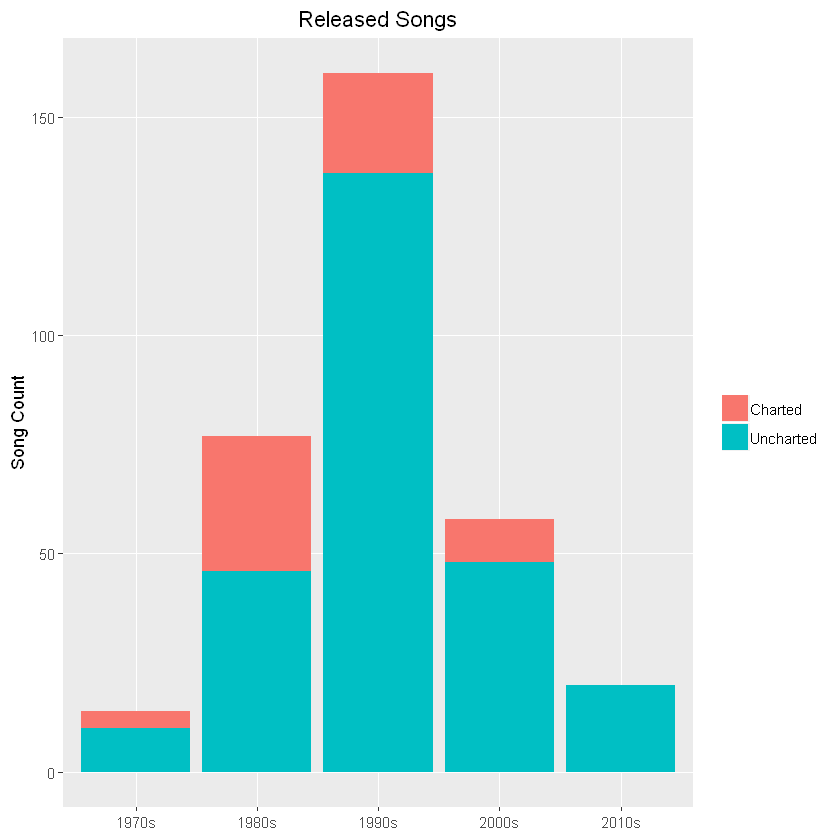

In [63]:
prince %>%
  filter(decade != "NA") %>%
  group_by(decade, charted) %>%
  summarise(number_of_songs = n()) %>%
  ggplot() + 
  geom_bar(aes(x = decade, y = number_of_songs, 
               fill = charted), stat = "identity")  +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        panel.grid.minor = element_blank()) +
  ggtitle("Released Songs") +
  labs(x = NULL, y = "Song Count")

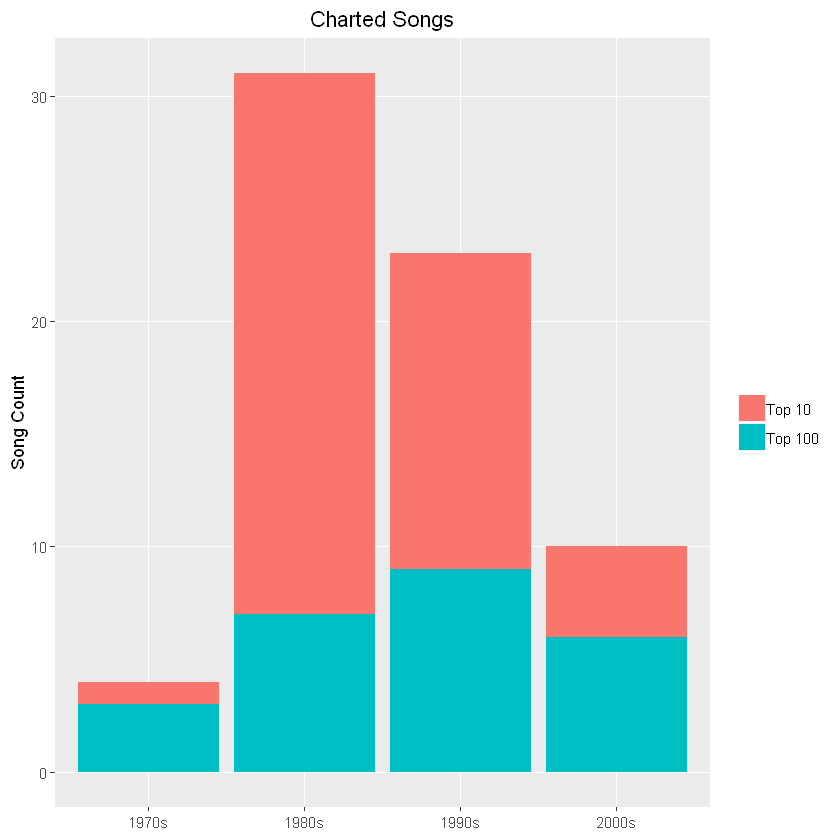

In [64]:
charted_songs_over_time <- prince %>%
  filter(peak > 0) %>%
  group_by(decade, chart_level) %>%
  summarise(number_of_songs = n())

charted_songs_over_time %>% 
  ggplot() + 
  geom_bar(aes(x = decade, y = number_of_songs, 
               fill = chart_level), stat = "identity") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        panel.grid.minor = element_blank()) +
  labs(x = NULL, y = "Song Count") +
  ggtitle("Charted Songs")

In [65]:
undesirable_words <- c("prince", "chorus", "repeat", "lyrics", 
                       "theres", "bridge", "fe0f", "yeah", "baby", 
                       "alright", "wanna", "gonna", "chorus", "verse", 
                       "whoa", "gotta", "make", "miscellaneous", "2", 
                       "4", "ooh", "uurh", "pheromone", "poompoom", "3121", 
                       "matic", " ai ", " ca ", " la ", "hey", " na ", 
                       " da ", " uh ", " tin ", "  ll", "transcription",
                       "repeats")

In [66]:
#unnest and remove stop, undesirable and short words
prince_words_filtered <- prince %>%
  unnest_tokens(word, lyrics) %>%
  anti_join(stop_words) %>%
  distinct() %>%
  filter(!word %in% undesirable_words) %>%
  filter(nchar(word) > 3)

Joining, by = "word"


In [67]:
 prince_words_filtered %>% 
  filter(word == "race") %>%
  select(word, song, year, peak, decade, chart_level, charted) %>%
  arrange() %>%
  top_n(10,song) %>%
  mutate(song = color_tile("lightblue","lightblue")(song)) %>%
  mutate(word = color_tile("lightgreen","lightgreen")(word)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Tokenized Format Example") %>%
  kable_styling(bootstrap_options = 
                  c("striped", "condensed", "bordered"), 
                  full_width = FALSE)

Warning message in gradient(as.numeric(x), ...):
"NAs introduced by coercion"Warning message in gradient(as.numeric(x), ...):
"NAs introduced by coercion"

<table class="table table-striped table-condensed table-bordered" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>Tokenized Format Example</caption>
 <thead>
  <tr>
   <th style="text-align:center;"> word </th>
   <th style="text-align:center;"> song </th>
   <th style="text-align:center;"> year </th>
   <th style="text-align:center;"> peak </th>
   <th style="text-align:center;"> decade </th>
   <th style="text-align:center;"> chart_level </th>
   <th style="text-align:center;"> charted </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:center;"> <span style="display: block; padding: 0 4px; border-radius: 4px; background-color: #90ee90">race</span> </td>
   <td style="text-align:center;"> <span style="display: block; padding: 0 4px; border-radius: 4px; background-color: #add8e6">lovesexy              </span> </td>
   <td style="text-align:center;"> 1988 </td>
   <td style="text-align:center;"> 1 </td>
   <td style="text-align:center;"> 198

In [68]:
full_word_count <- prince %>%
  unnest_tokens(word, lyrics) %>%
  group_by(song,chart_level) %>%
  summarise(num_words = n()) %>%
  arrange(desc(num_words)) 

full_word_count[1:10,] %>%
  ungroup(num_words, song) %>%
  mutate(num_words = color_bar("lightblue")(num_words)) %>%
  mutate(song = color_tile("lightpink","lightpink")(song)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Songs With Highest Word Count") %>%
  kable_styling(bootstrap_options = 
                  c("striped", "condensed", "bordered"), 
                  full_width = FALSE)

Warning message in gradient(as.numeric(x), ...):
"NAs introduced by coercion"

<table class="table table-striped table-condensed table-bordered" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>Songs With Highest Word Count</caption>
 <thead>
  <tr>
   <th style="text-align:center;"> song </th>
   <th style="text-align:center;"> chart_level </th>
   <th style="text-align:center;"> num_words </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:center;"> <span style="display: block; padding: 0 4px; border-radius: 4px; background-color: #ffb6c1">johnny              </span> </td>
   <td style="text-align:center;"> Uncharted </td>
   <td style="text-align:center;"> <span style="display: inline-block; direction: rtl; border-radius: 4px; padding-right: 2px; background-color: lightblue; width: 100.00%">1349</span> </td>
  </tr>
  <tr>
   <td style="text-align:center;"> <span style="display: block; padding: 0 4px; border-radius: 4px; background-color: #ffb6c1">cloreen bacon skin  </span> </td>
   <td style="text-align:center;"> U

# Loading original dataset

In [4]:
lyrics_dataset_orig <- read.csv('lyrics.csv', stringsAsFactors = FALSE)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"

In [5]:
names(lyrics_dataset_orig)

[1] "index"  "song"   "year"   "artist" "genre"  "lyrics"

In [6]:
dim(lyrics_dataset_orig)

[1] 339277      6

In [36]:
#define some colors to use throughout
my_colors <- c("#E69F00", "#56B4E9", "#009E73", "#CC79A7", "#D55E00", "#D65E00")

#customize ggplot2's default theme settings
#this tutorial doesn't actually pass any parameters, but you may use it again in future tutorials so it's nice to have the options
theme_lyrics <- function(aticks = element_blank(),
                         pgminor = element_blank(),
                         lt = element_blank(),
                         lp = "none")
{
  theme(plot.title = element_text(hjust = 0.5), #center the title
        axis.ticks = aticks, #set axis ticks to on or off
        panel.grid.minor = pgminor, #turn on or off the minor grid lines
        legend.title = lt, #turn on or off the legend title
        legend.position = lp) #turn on or off the legend
}

#customize the text tables for consistency using HTML formatting
my_kable_styling <- function(dat, caption) {
  kable(dat, "html", escape = FALSE, caption = caption) %>%
  kable_styling(bootstrap_options = c("striped", "condensed", "bordered"),
                full_width = FALSE)
}

word_chart <- function(data, input, title) {
  data %>%
  #set y = 1 to just plot one variable and use word as the label
  ggplot(aes(as.factor(row), 1, label = input, fill = factor(topic) )) +
  #you want the words, not the points
  geom_point(color = "transparent") +
  #make sure the labels don't overlap
  geom_label_repel(nudge_x = .2,  
                   direction = "y",
                   box.padding = 0.1,
                   segment.color = "transparent",
                   size = 3) +
  facet_grid(~topic) +
  theme_lyrics() +
  theme(axis.text.y = element_blank(), axis.text.x = element_blank(),
        #axis.title.x = element_text(size = 9),
        panel.grid = element_blank(), panel.background = element_blank(),
        panel.border = element_rect("lightgray", fill = NA),
        strip.text.x = element_text(size = 9)) +
  labs(x = NULL, y = NULL, title = title) +
    #xlab(NULL) + ylab(NULL) +
  #ggtitle(title) +
  coord_flip()
}

In [7]:
lyrics_dataset_orig[lyrics_dataset_orig == ''] <- NA

In [8]:
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'song')
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'genre')
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'lyrics')
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'year')

In [9]:
dim(lyrics_dataset_orig)

[1] 249828      6

In [10]:
glimpse(lyrics_dataset_orig[16308, ])

Observations: 1
Variables: 6
$ index  <int> 22821
$ song   <chr> "for-the-music"
$ year   <int> 2013
$ artist <chr> "grapefruit-sound-lab"
$ genre  <chr> "Not Available"
$ lyrics <chr> "We came here for the music\nWe came here for the sound\nWe'...


In [11]:
unique(lyrics_dataset_orig$genre)

[1] "Pop"           "Hip-Hop"       "Not Available" "Rock"         
 [5] "Metal"         "Other"         "Country"       "Jazz"         
 [9] "Electronic"    "Folk"          "R&B"           "Indie"

##### Selecting 5000 songs from each genre

In [146]:
pop <- sample_n(subset(lyrics_dataset_orig, genre == 'Pop'), 5000)
rock <- sample_n(subset(lyrics_dataset_orig, genre == 'Rock'), 5000)
jazz <- sample_n(subset(lyrics_dataset_orig, genre == 'Jazz'), 5000)
hiphop <- sample_n(subset(lyrics_dataset_orig, genre == 'Hip-Hop'), 5000)
country <- sample_n(subset(lyrics_dataset_orig, genre == 'Country'), 5000)
metal <- sample_n(subset(lyrics_dataset_orig, genre == 'Metal'), 5000)
electronic <- sample_n(subset(lyrics_dataset_orig, genre == 'Electronic'), 5000)
folk <- sample_n(subset(lyrics_dataset_orig, genre == 'Other'), 4858)

In [201]:
lyrics_dataset <- rbind(pop, rock, hiphop)

In [230]:
head(lyrics_dataset)

index,song,year,artist,genre,lyrics
159192,three-love,2009,britney-spears,Pop,"1, 2, 3 Not only you and me Got one eighty degrees And I'm caught in between Countin' 1, 2, 3 Peter, Paul & Mary Gettin' down with 3P Everybody loves *** Countin' Babe, pick a night To come out and play If it's alright What do you say? Merrier the more Triple fun that way Twister on the floor What do you say? Are - you in Livin' in sin is the new thing (yeah) Are - you in I am countin'! 1, 2, 3 Not only you and me Got one eighty degrees And I'm caught in between Countin' 1, 2, 3 Peter, Paul & Mary Gettin' down with 3P Everybody loves *** Countin' Three is a charm Two is not the same I don't see the harm So are you game? Lets' make a team Make 'em say my name Lovin' the extreme Now are you game? Are - you in Livin' in sin is the new thing Are - you in I am countin'! 1, 2, 3 Not only you and me Got one eighty degrees And I'm caught in between Countin' 1, 2, 3 Peter, Paul & Mary Gettin' down with 3P 1, 2, 3 Not only you and me Got one eighty degrees And I'm caught in between Countin' 1, 2, 3 Peter, Paul & Mary Gettin' down with 3P Everybody loves *** Countin' Babe, pick a night To come out and play If it's alright What do you say? Merrier the more Triple fun that way Twister on the floor What do you say? Are - you in Livin' in sin is the new thing (yeah) Are - you in I am countin'! 1, 2, 3 Not only you and me Got one eighty degrees And I'm caught in between Countin' 1, 2, 3 Peter, Paul & Mary Gettin' down with 3P Everybody loves *** Countin' Three is a charm Two is not the same I don't see the harm So are you game? Lets' make a team Make 'em say my name Lovin' the extreme Now are you game? Are - you in Livin' in sin is the new thing Are - you in I am countin'! 1, 2, 3 Not only you and me Got one eighty degrees And I'm caught in between Countin' 1, 2, 3 Peter, Paul & Mary Gettin' down with 3P Everybody loves *** What we do is innocent Just for fun and nothin' meant If you don't like the company Let's just do it you and me You and me... Or three.... Or four.... - On the floor! Everybody loves *** What we do is innocent Just for fun and nothin' meant If you don't like the company Let's just do it you and me You and me... Or three.... Or four.... - On the floor!"
249163,the-best-year-of-my-life,2014,eddie-rabbitt,Pop,"We'll go down in history Me lovin' you You lovin' me, yeah There's something about The way you kiss It's in the stars, baby We can't miss, no Before you came along My heart was down Then you walked right in And turned my world around The best year of my life Is the year that just went by Since I met you The best year of my life Is the year that you made All my dreams come true And you'll always be the one And every year to come Will be the best year of my life Baby, since you came along My life's turned into a song, yeah And in your misty eyes I see Way beyond eternity, yeah Your special kind of lovin' never fades It just keeps on growin' Stronger every day The best year of my life Is the year that just went by Since I met you The best year of my life Is the year that you made All my dreams come true And you'll always be the one And every year to come Will be the best year of my life The best year of my life Is the year that just went by Since I met you The best year of my life Is the year that you made All my dreams come true And you'll always be the one And every year to come Will be the best year of my life The best year of my life"
281793,les-yeux-ouverts,2008,beautiful-south,Pop,"Ce souvenir je te le rends. Des souvenirs, tu sais j'en ai tellement. Puisqu'on repart toujours ÃƒÂ zÃƒÂ©ro. Pas la peine de s'charger trop... Ce souvenir je te le prends. Des souvenirs, comme ca j'en veux tout le temps. Si par erreur la vie nous separe, J'le sortirai d'mon tiroir. J'rÃƒÂªve les yeux ouverts. Ca m'fait do bien. Ca ne va pas plus loin. J'veux pas voir derriere Puisque j'en viens. Vivement demain. Mon bonheur te resemble Tous les deux vous allez s

In [202]:
dim(lyrics_dataset)

[1] 15000     6

In [203]:
lyrics <- lyrics_dataset %>%
        select(song, lyrics, genre)
glimpse(lyrics[1310, ])

Observations: 1
Variables: 3
$ song   <chr> "the-build-up"
$ lyrics <chr> "The build-up\nLasted for days\nLasted for weeks\nLasted too...
$ genre  <chr> "Pop"


##### Basic Cleaning

In [204]:
# function to expand contractions in an English-language source
fix.contractions <- function(doc) {
  # "won't" is a special case as it does not expand to "wo not"
  doc <- gsub("won't", "will not", doc)
  doc <- gsub("can't", "can not", doc)
  doc <- gsub("n't", " not", doc)
  doc <- gsub("'ll", " will", doc)
  doc <- gsub("'re", " are", doc)
  doc <- gsub("'ve", " have", doc)
  doc <- gsub("'m", " am", doc)
  doc <- gsub("'d", " would", doc)
  # 's could be 'is' or could be possessive: it has no expansion
  doc <- gsub("'s", "", doc)
  return(doc)
}

# fix (expand) contractions
lyrics$lyrics <- sapply(lyrics$lyrics, fix.contractions)

In [205]:
glimpse(lyrics[1, ])

Observations: 1
Variables: 3
$ song   <chr> "three-love"
$ lyrics <chr> "1, 2, 3\nNot only you and me\nGot one eighty degrees\nAnd I...
$ genre  <chr> "Pop"


In [206]:
# function to remove special characters
removeSpecialChars <- function(x) gsub("[^a-zA-Z0-9 ]", " ", x)
# remove special characters
lyrics$lyrics <- sapply(lyrics$lyrics, removeSpecialChars)

In [207]:
# convert everything to lower case
lyrics$lyrics <- sapply(lyrics$lyrics, tolower)

In [208]:
#unnest and remove stop and short words
lyrics_words_filtered <- lyrics %>%
  unnest_tokens(word, lyrics) %>%
  anti_join(stop_words) %>%
  distinct() %>%
  filter(nchar(word) > 3)

Joining, by = "word"


In [209]:
glimpse(lyrics[1, ])

Observations: 1
Variables: 3
$ song   <chr> "three-love"
$ lyrics <chr> "1  2  3 not only you and me got one eighty degrees and i am...
$ genre  <chr> "Pop"


In [210]:
dim(lyrics_words_filtered)

[1] 922386      3

In [211]:
#group the dataset by writer (source) and count the words
lyrics_words_filtered %>%
  group_by(genre) %>%
  mutate(word_count = n()) %>%
  select(genre, word_count) %>% #only need these fields
  distinct() %>%
  ungroup() %>%
  #assign color bar for word_count that varies according to size
  #create static color for source and genre
  mutate(word_count = (word_count),
         genre = (genre)) %>%
  print(word_count)

# A tibble: 3 x 2
  genre   word_count
  <chr>        <int>
1 Pop         190654
2 Rock        176620
3 Hip-Hop     555112


In [212]:
lyrics_words_filtered <- lyrics_words_filtered %>%
                        unite(song_genre, song, genre)

In [213]:
lyrics_words_dtm_filtered <- lyrics_words_filtered %>%
  #get word count per document to pass to cast_dtm
  count(song_genre, word, sort = TRUE) %>%
  ungroup() %>%
  #create a DTM with docs as rows and words as columns
  cast_dtm(song_genre, word, n)
#examine the structure of the DTM
lyrics_words_dtm_filtered

<<DocumentTermMatrix (documents: 14328, terms: 88715)>>
Non-/sparse entries: 922386/1270186134
Sparsity           : 100%
Maximal term length: 47
Weighting          : term frequency (tf)

In [214]:
inspect(lyrics_words_dtm_filtered[1:4,1:8])

<<DocumentTermMatrix (documents: 4, terms: 8)>>
Non-/sparse entries: 8/24
Sparsity           : 75%
Maximal term length: 9
Weighting          : term frequency (tf)
Sample             :
                            Terms
Docs                         abdu accident ache acid adding afar answers
  0-to-100-freestyle_Hip-Hop    1        1    1    1      1    1       1
  0-to-100_Hip-Hop              0        0    0    0      0    0       0
  05-par-dni_Rock               0        0    0    0      0    0       0
  1-1_Pop                       0        0    0    0      0    0       0
                            Terms
Docs                         backpacks
  0-to-100-freestyle_Hip-Hop         1
  0-to-100_Hip-Hop                   0
  05-par-dni_Rock                    0
  1-1_Pop                            0


In [215]:
genre_dtm <- lyrics_words_dtm_filtered
genre_tidy <- lyrics_words_filtered

In [216]:
k <- 3 #number of topics
seed = 1234 #necessary for reproducibility
#fit the model passing the parameters discussed above
#you could have more control parameters but will just use seed here
lda <- LDA(genre_dtm, k = k, method = "GIBBS", control = list(seed = seed))
#examine the class of the LDA object
class(lda)

[1] "LDA_Gibbs"
attr(,"package")
[1] "topicmodels"

In [217]:
#convert the LDA object into a tidy format
#passing "beta" shows the word probabilities
#filter on the word iceberg as an example
#results show probability of iceberg for each topic
tidy(lda, matrix = "beta") %>% filter(term == "rivers")

topic,term,beta
1,rivers,2.402157e-07
2,rivers,4.909048e-07
3,rivers,1.735549e-04


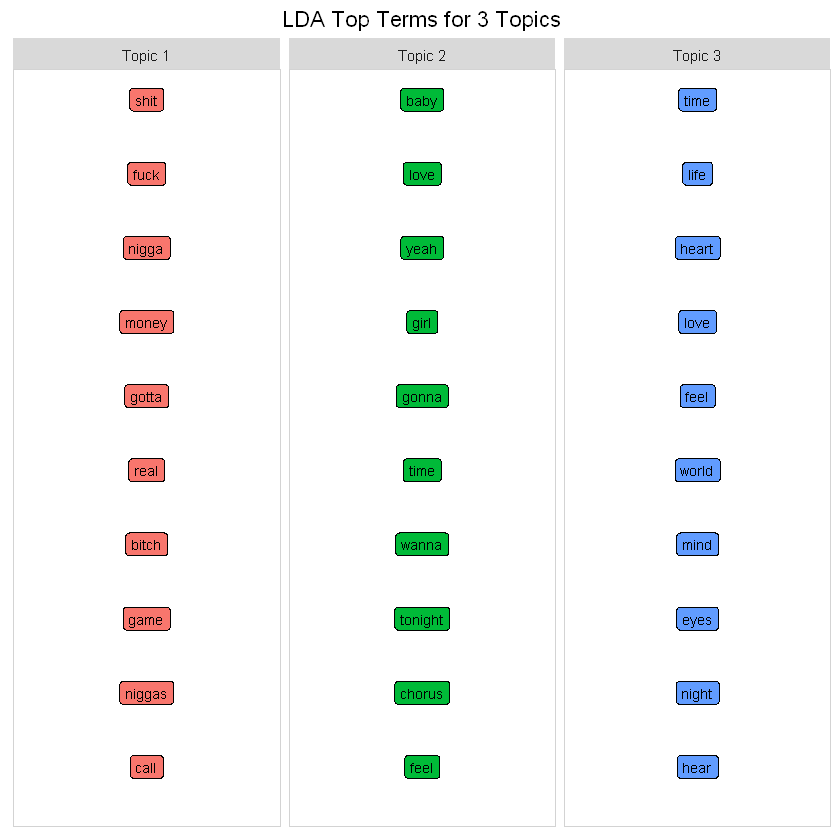

In [218]:
num_words <- 10 #number of words to visualize

#create function that accepts the lda model and num word to display
top_terms_per_topic <- function(lda_model, num_words) {

  #tidy LDA object to get word, topic, and probability (beta)
  topics_tidy <- tidy(lda_model, matrix = "beta")


  top_terms <- topics_tidy %>%
  group_by(topic) %>%
  arrange(topic, desc(beta)) %>%
  #get the top num_words PER topic
  slice(seq_len(num_words)) %>%
  arrange(topic, beta) %>%
  #row is required for the word_chart() function
  mutate(row = row_number()) %>%
  ungroup() %>%
  #add the word Topic to the topic labels
  mutate(topic = paste("Topic", topic, sep = " "))
  #create a title to pass to word_chart
  title <- paste("LDA Top Terms for", k, "Topics")
  #call the word_chart function you built in prep work
  word_chart(top_terms, top_terms$term, title)
}
#call the function you just built!
top_terms_per_topic(lda, num_words)

In [219]:
#this time use gamma to look at the prob a doc is in a topic
#just look at the Prince song 1999 as an example
tidy(lda, matrix = "gamma") %>% filter(document == "rivers-of-babylon_Pop")
# tidy(lda, matrix = "gamma") %>% filter(document == "if-god-can-forgive-me-why-can-t-you")

document,topic,gamma


In [220]:
songs_gamma <- tidy(lda, matrix = 'gamma')
head(songs_gamma)
# songs_gamma[songs_gamma == 'angel']
# class(songs_gamma)
dim(songs_gamma)

document,topic,gamma
0-to-100-freestyle_Hip-Hop,1,0.6655443
0-to-100_Hip-Hop,1,0.6510172
05-par-dni_Rock,1,0.2341270
1-1_Pop,1,0.3425926
1-2-crush-on-you_Rock,1,0.3755869
1-2-many_Hip-Hop,1,0.5788423


[1] 42984     3

In [221]:
songs_gamma <- songs_gamma %>% separate(document, c('song', 'genre'), sep = '_', convert = TRUE)
songs_gamma

song,genre,topic,gamma
0-to-100-freestyle,Hip-Hop,1,0.6655443
0-to-100,Hip-Hop,1,0.6510172
05-par-dni,Rock,1,0.2341270
1-1,Pop,1,0.3425926
1-2-crush-on-you,Rock,1,0.3755869
1-2-many,Hip-Hop,1,0.5788423
1-2-the-3,Hip-Hop,1,0.6879756
1-adam-12,Hip-Hop,1,0.5571205
1-grote-liefde,Pop,1,0.2327044
1-the-long-way-down,Rock,1,0.3434343


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


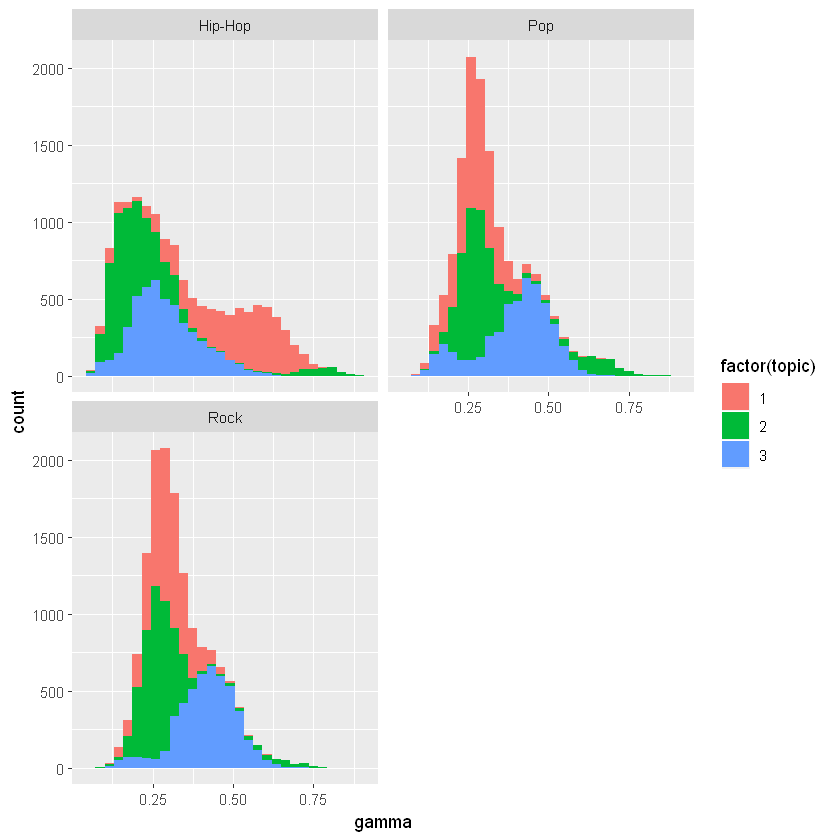

In [222]:
ggplot(songs_gamma, aes(gamma, fill = factor(topic))) +
  geom_histogram() +
  facet_wrap(~ genre, nrow = 2)

In [223]:
song_classifications <- songs_gamma %>%
  group_by(genre, song) %>%
  top_n(1, gamma) %>%
  ungroup() %>%
  arrange(gamma)

song_classifications

song,genre,topic,gamma
amuse-bouche,Pop,1,0.3333333
ballet-for-a-girl-in-buchannon-now-more-than-ever,Rock,1,0.3333333
before-the-ship-goes-down,Rock,1,0.3333333
blue-romanized-version,Pop,1,0.3333333
clumsy-remix,Pop,1,0.3333333
courage-interlude,Pop,1,0.3333333
don-t-wanna-lose-this-feeling,Pop,1,0.3333333
i-like-to-move-it,Pop,1,0.3333333
junk,Pop,1,0.3333333
knock-knock,Rock,1,0.3333333


In [224]:
song_genre <- song_classifications %>%
  count(genre, topic) %>%
  group_by(topic) %>%
  top_n(1, n) %>%
  ungroup() %>%
  transmute(predicted = genre, topic)

song_genre

predicted,topic
Hip-Hop,1
Pop,2
Rock,3


In [225]:
song_classifications_counts <- song_classifications %>%
  inner_join(song_genre, by = "topic") %>%
  count(genre, predicted)
song_classifications_counts

genre,predicted,n
Hip-Hop,Hip-Hop,3601
Hip-Hop,Pop,407
Hip-Hop,Rock,815
Pop,Hip-Hop,528
Pop,Pop,919
Pop,Rock,3394
Rock,Hip-Hop,649
Rock,Pop,543
Rock,Rock,3758


In [226]:
# sum(song_classifications_counts$n)
misclassified = 0
for(i in 1:nrow(song_classifications_counts)) {
    if(song_classifications_counts$genre[i] != song_classifications_counts$predicted[i]) {
        misclassified = misclassified + song_classifications_counts$n[i]
    }
}

In [227]:
misclassified/(sum(song_classifications_counts$n))

[1] 0.4335569